# RooFit Tutorial: Fit Cosmological Models to Type 1a Supernova Data
### Created:  Summer 2017 Harrison B. Prosper
## Introduction
In this tutorial, we use the probability modeling package __[RooFit](https://root.cern.ch/roofit-20-minutes)__, released with the CERN data analysis package __[ROOT](http://root.cern.ch)__, to perform fits of simple cosmological models to Type 1a supernova data. See the __minuit_example.ipynb__ to get some background to this problem. 

__prerequisite__: some familiarity with __[Python](http://www.python.org)__ and __[ROOT](http://root.cern.ch)__ is helpful.

### Load Type 1a utilities

In [1]:
%run ../type1autil.ipynb

Welcome to JupyROOT 6.24/00


### Read Type 1a supernova data 

number of observations: 580
     	         z	         x +/- dx        
    0	     0.028	   35.3466 +/- 0.2239    
  100	     0.065	   37.3067 +/- 0.1628    
  200	     0.194	   39.9615 +/- 0.1264    
  300	     0.620	   43.2280 +/- 0.3903    
  400	     0.710	   43.0220 +/- 0.1843    
  500	     0.564	   42.3729 +/- 0.2920    

fig_union_2_1_data.pdf


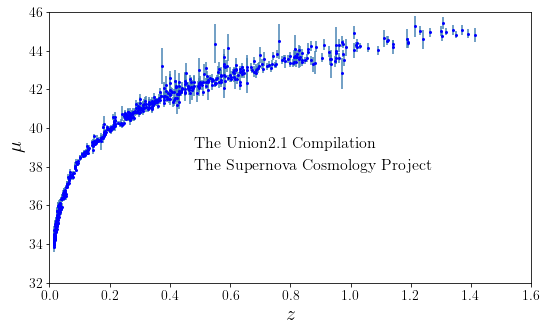

In [2]:
# place results in a bag for later use
class Bag: pass

bag = Bag()

filename = '../SCPUnion2.1_mu_vs_z.txt'

bag.z, bag.mu, bag.dmu = read_data(filename)

plot_data(bag)

### Choose model
   * 'LCDM' or 'phantom'
   * Compile C++ CosmicCode using ROOT

In [3]:
bag.name = 'LCDM'

bag.code, bag.params = compileCode(bag, PARAMS)

# initialize a C array for the parameters; this is needed for
# distanceModulus
bag.p = array('d')

print('\nInitial values of free parameters for %s model' % bag.name)

for name, value, _, _ in bag.params:
    bag.p.append(value)
    print('%s\t%5.2f' % (name, value)) 
        
guess = np.array(bag.p)


Initial values of free parameters for LCDM model
OM	 0.30
OL	 0.70
H0	70.00

	LCDM model



### Create workspace
Create an empty workspace called __Type1a__. This is useful for at least two reasons. First, you may wish to save the probability model you have created to a ROOT file. Second, it is much more convenient to use the workspace methods to build a model than to use the __[RooFit](https://root.cern.ch/roofit-20-minutes)__ C++ classes directly.

In [4]:
# suppress all messages except fatal ones
ROOT.RooMsgService.instance().setGlobalKillBelow(ROOT.RooFit.WARNING)

# add to bag
bag.wspace = ROOT.RooWorkspace('Type1a')


RooFit v3.60 -- Developed by Wouter Verkerke and David Kirkby 
                Copyright (C) 2000-2013 NIKHEF, University of California & Stanford University
                All rights reserved, please read http://roofit.sourceforge.net/license.txt



### Create parameters
Create RooFit parameters using the workspace factory method. 

In [5]:
def create_parameters(bag,
                      zmin=ZMIN, zmax=ZMAX, 
                      mumin=MUMIN, mumax=MUMAX):
    # create an alias
    wspace = bag.wspace
       
    # measured distance modulus
    wspace.factory('mu[%f, %f]' % (mumin, mumax))

    # measured redshift
    wspace.factory('z[%f, %f]' % (zmin, zmax))

    # distance modulus uncertainty
    wspace.factory('dmu[0.01, 5.0]')

    wspace.defineSet('set_data', 'z,mu,dmu')
    
    # cosmological parameters
    p = [] # parameters to be passed to distanceModulus
    args  = 'z'
    for name, guess, pmin, pmax in bag.params:
        cmd = '%s[%f, %f, %f]' % (name, guess, pmin, pmax)
        wspace.factory(cmd)
        print(cmd)
        args += ',%s' % name
        p.append(guess)
      
    # place them in the bag
    bag.p = array('d')
    bag.p.fromlist(p)
    
    wspace.defineSet('set_arguments', args)
    wspace.Print()

In [6]:
create_parameters(bag)

OM[0.300000, 0.000000, 10.000000]
OL[0.700000, 0.000000, 10.000000]
H0[70.000000, 1.000000, 200.000000]

RooWorkspace(Type1a) Type1a contents

variables
---------
(H0,OL,OM,dmu,mu,z)

named sets
----------
set_arguments:(z,OM,OL,H0)
set_data:(z,mu,dmu)



### Add data to workspace

In [7]:
def add_data_to_workspace(bag):
    wspace = bag.wspace
    
    # create a RooFit data set
    set_data = wspace.set('set_data')
    dataset  = ROOT.RooDataSet('data', 'Type 1a data', set_data)
    
    for ii, (u, x, dx) in enumerate(zip(bag.z, bag.mu, bag.dmu)):
        if ii % 100 == 0:
            print("%5d\t%10.3f\t%10.4f +/- %-10.4f"% (ii, u, x, dx))
            
        set_data['z'].setVal(u)
        set_data['mu'].setVal(x)
        set_data['dmu'].setVal(dx)
        dataset.add(set_data)
            
    # import data set into workspace
    getattr(wspace, 'import')(dataset)
    
    wspace.Print()

In [8]:
add_data_to_workspace(bag)

    0	     0.028	   35.3466 +/- 0.2239    
  100	     0.065	   37.3067 +/- 0.1628    
  200	     0.194	   39.9615 +/- 0.1264    
  300	     0.620	   43.2280 +/- 0.3903    
  400	     0.710	   43.0220 +/- 0.1843    
  500	     0.564	   42.3729 +/- 0.2920    

RooWorkspace(Type1a) Type1a contents

variables
---------
(H0,OL,OM,dmu,mu,z)

datasets
--------
RooDataSet::data(z,mu,dmu)

named sets
----------
set_arguments:(z,OM,OL,H0)
set_data:(z,mu,dmu)



### Create probability model
We assume a Gaussian probability density function (pdf),

$$f(\mu \, | \, z, \sigma, \theta) = \textrm{Gauss}(\mu, m(z, \theta), \sigma),$$

where $\mu$ and $z$ are the measured distance modulus and red-shift, respectively, and $\theta$ are the parameters of the cosmological model $m$ for the distance modulus. Neglecting correlations amongst the data, the likelihood is given by

$$p(\mu \,| \, z, \sigma, \theta) = \prod_{i=1}^N \, f(\mu_i \, | \, z_i, \sigma_i, \theta),$$

with $N = 580$. For a Bayesian calculation, we would, in addition, specify a prior density $\pi(\theta)$ for the cosmological parameters. We assume that $z_i$ and $\sigma_i$ are known with negligible uncertainty.

#### A useful bit of ROOT magic: mixing in a bit of C++
Here we create a bit of C++ code, which will be visible to both ROOT and Python. The object __code__ and the function __distanceModulus__ are used below in the definition of the probability model. 

Note the hack to make __code__ object visible to ROOT.

In [9]:
addr = bag.code.__str__()[1:-1].split()[-1]
cmd  = "CosmicCode* code = (CosmicCode*)%s" % addr
ROOT.gROOT.ProcessLine(cmd);

(CosmicCode *) 0x7ff015a41aa0


In [10]:
%%cpp -d
double distanceModulus(double z, 
                       double OM, 
                       double OL, 
                       double H0) 
{
    double p[3] = {OM, OL, H0};
    return code->distanceModulus(z, p);
}

double distanceModulus(double z, 
                       double n, 
                       double H0) 
{
    double p[2] = {n, H0};
    return code->distanceModulus(z, p);
}

Check that the hack works.

In [11]:
print(ROOT.distanceModulus(1, 0.3, 0.7, 70))
print(bag.code.distanceModulus(1, bag.p))

44.094488425239334
44.094488425239334


In [12]:
def create_model(bag):
    #--------------------------------------------------------------    
    # create distance modulus expression "m".
    # note use of compiled C++ program for expressions that are too
    # complicated to be written inline
    #--------------------------------------------------------------
    wspace = bag.wspace
 
    set_arguments = wspace.set('set_arguments')
    arguments = ','.join([i.GetName()  for i in set_arguments])
    cmd = 'distanceModulus(%s)\n' % arguments
    print(cmd)
    
    # creating fmu = distanceModulus(z, ...)
    m = ROOT.RooFormulaVar('m', 'm', cmd, 
                           ROOT.RooArgList(set_arguments))

    # import the "m" expression into workspace
    getattr(wspace,'import')(m)

    # finally, create probability model
    wspace.factory('Gaussian::model(mu, m, dmu)')
    wspace.Print()

In [13]:
create_model(bag)

distanceModulus(z,OM,OL,H0)


RooWorkspace(Type1a) Type1a contents

variables
---------
(H0,OL,OM,dmu,mu,z)

p.d.f.s
-------
RooGaussian::model[ x=mu mean=m sigma=dmu ] = 0.42012

functions
--------
RooFormulaVar::m[ actualVars=(z,OM,OL,H0) formula="distanceModulus(x[0],x[1],x[2],x[3])
" ] = 42.8325

datasets
--------
RooDataSet::data(z,mu,dmu)

named sets
----------
set_arguments:(z,OM,OL,H0)
set_data:(z,mu,dmu)



### Save workspace to a ROOT file 

In [14]:
filename = '%s_workspace.root' % bag.name
if bag.wspace.writeToFile(filename) != 0:
    print("** problem saveing workspace to ROOT file %s" % filename)




## PART 2: Perform Fit

Ordinarily, this part would be performed in a separate session, which would require loading the workspace back into memory as follows:

```python
    filename = '%s_workspace.root' % MODEL
    rfile = TFile(filename)
    if not rfile.IsOpen():
        exit("** can't open file %s" % filename)

    name = 'Type1a'
    wspace = rfile.Get(name)
    if wspace == None:
        exit("** can't get workspace %s from file %s" % \
             (name, filename))
```

However, we shall just continue with the workspace already in memory.

In [20]:
def minimize(bag, printLevel=-1):
    wspace = bag.wspace

    swatch = ROOT.TStopwatch()
    swatch.Start()

    # save results of fit
    ROOT.RooMsgService.instance().\
        setGlobalKillBelow(ROOT.RooFit.FATAL)
    
    model= wspace.pdf('model')
    data = wspace.data('data')
    res  = model.fitTo(data, 
                       ROOT.RooFit.Save(),
                       ROOT.RooFit.PrintLevel(printLevel))
    
    print("real time: %10.3f s" % swatch.RealTime())
    print()
    res.Print()
    
    c = res.covarianceMatrix()
    x = []
    cov = []
    for i, (name, guess, _, _) in enumerate(bag.params):
        x.append(wspace.var(name).getVal())
        cov.append([])
        for j in range(len(bag.params)):
            cov[-1].append(c[i][j])
    return (np.array(x), np.array(cov))

In [21]:
bag.x, bag.cov = minimize(bag)

real time:      2.842 s


  RooFitResult: minimized FCN value: 2404.32, estimated distance to minimum: 2.21797e-06
                covariance matrix quality: Full, accurate covariance matrix
                Status : MINIMIZE=0 HESSE=0 

    Floating Parameter    FinalValue +/-  Error   
  --------------------  --------------------------
                    H0    6.9643e+01 +/-  4.41e-01
                    OL    5.9432e-01 +/-  1.24e-01
                    OM    1.6966e-01 +/-  7.51e-02



In [24]:
def nll(pars, *args):
    bag = args[0]
    
    # copy from numpy array to regular array
    for i, v in enumerate(pars): bag.p[i] = v
   
    f = np.array([ROOT.code.distanceModulus(u, bag.p) for u in bag.z])      
    c = (bag.mu - f) / bag.dmu
    c = c * c 
    return c.sum()/2

### Plot Results


fig_LCDM_union_2_1_fit.pdf


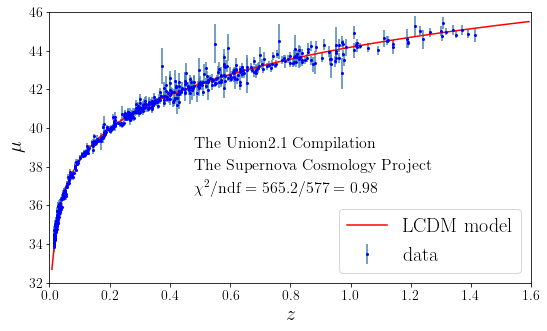

In [26]:
plot_data(bag, nll)

### Plot predicted scale factor vs. time


fig_LCDM_scale_factor.pdf


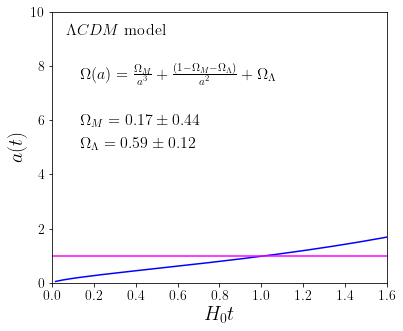

In [27]:
plot_scale_factor(bag)